# XGBOOST Explanation

This notebook is focused on the explanation of the XGBoost model used to perform the `Task 4: classification`.

## Preparation of the model

In [1]:
from os import path
import pandas as pd
from preprocessing import get_train_test_data
from transformations import center_and_scale, drop_boolean
train_data, train_labels, test_data, test_labels, columns_to_keep = get_train_test_data()

# casting of boolean columns to int, necessary for SHAP to work
train_data = train_data.astype({col: 'int' for col in train_data.select_dtypes('bool').columns})
test_data = test_data.astype({col: 'int' for col in test_data.select_dtypes('bool').columns})

full_dataset = pd.concat((train_data, test_data))

In [2]:
from sklearn.utils import resample
import pandas as pd

# Combine train_data and y_train in a unique dataset
train_set = pd.concat([train_data, train_labels], axis=1)
train_set.columns = list(train_data.columns) + ['top_20']  # Dai un nome alla colonna 'label'

# Divide between majority and minority classes
majority_class = train_set[train_set['top_20'] == 0]
minority_class = train_set[train_set['top_20'] == 1]

# Number of sampling to mantain
samples_per_class = len(majority_class)

# oversampling of the minority class
minority_upsampled = resample(
    minority_class,
    replace=True,                # Sampling with replacement
    n_samples=samples_per_class, # Number of sampling equals to majority class
    random_state=42
)

# combine the two classes in a balanced dataset
balanced_train_set = pd.concat([majority_class, minority_upsampled])

# divide between features and label
train_data = balanced_train_set.drop(columns=['top_20'])
train_labels = balanced_train_set['top_20']

print("Distribution of the balaced classses:")
print(train_labels.value_counts())

Distribution of the balaced classses:
0    460644
1    460644
Name: top_20, dtype: int64


In [3]:
print(train_data.dtypes)

bmi                      float64
career_points            float64
career_duration(days)    float64
debut_year               float64
difficulty_score         float64
competitive_age            int64
is_tarmac                  int64
climbing_efficiency      float64
startlist_quality          int64
avg_pos                  float64
dtype: object


In [4]:
import pandas as pd
result = pd.read_csv('xgboostresult.csv').sort_values(by='val_f1_score',ascending=False).head(10)
result

,gamma,lambda,learning_rate,max_depth,min_child_weight,n_estimators,scale_pos_weight,train_f1_score,val_f1_score,test_f1_score,val_positives_f1_score,val_negatives_f1_score
161,0.0,2,1.0,3,3,250,1,0.724716,0.719851,0.618857,0.719851,0.719851
377,0.1,2,1.0,3,3,250,1,0.724716,0.719851,0.618857,0.719851,0.719851
593,0.2,2,1.0,3,3,250,1,0.724716,0.719851,0.618857,0.719851,0.719851
443,0.2,0,1.0,3,1,250,1,0.724164,0.719365,0.621626,0.719365,0.719365
11,0.0,0,1.0,3,1,250,1,0.724164,0.719365,0.621626,0.719365,0.719365
227,0.1,0,1.0,3,1,250,1,0.724164,0.719365,0.621626,0.719365,0.719365
302,0.1,1,1.0,3,2,250,1,0.724324,0.718828,0.615686,0.718828,0.718828
86,0.0,1,1.0,3,2,250,1,0.724324,0.718828,0.615686,0.718828,0.718828
155,0.0,2,1.0,3,1,250,1,0.725199,0.718815,0.620442,0.718815,0.718815
587,0.2,2,1.0,3,1,250,1,0.725199,0.718815,0.620442,0.718815,0.718815


In [5]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(
        gamma=0.0,
        reg_lambda=2,
        learning_rate=1.0,
        max_depth=3,
        min_child_weight=3,
        n_estimators=250,
        scale_pos_weight=1
)


xgbc.fit(train_data, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [6]:
from sklearn.metrics import classification_report

train_labels_model = xgbc.predict(train_data)
test_labels_model = xgbc.predict(test_data)
validation = classification_report(test_labels, test_labels_model, output_dict=True)

In [7]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label,
                            test_pred,
                            target_names=['0', '1']))

In [8]:
report_scores(test_labels, test_labels_model)

              precision    recall  f1-score   support

           0       0.92      0.76      0.83     30219
           1       0.30      0.59      0.40      5187

    accuracy                           0.74     35406
   macro avg       0.61      0.68      0.61     35406
weighted avg       0.82      0.74      0.77     35406



# Feature importance

In [9]:
perturbation_data = train_data
perturbation_labels = train_labels
perturbation_predictions = train_labels_model

explanation_data = test_data
explanation_labels = test_labels
explanation_predictions = test_labels_model

explanations = dict()

Here we we will analyse the feature importance of the Random Forest model that we have trained above. To do so, we will use the `shap` library. 
In particular, we will use the `shap.TreeExplainer` class to explain the predictions of the model because it is a tree-based model and it is the most appropriate class for this type of model.

In [10]:
import shap


interventional_explanation_algorithm = shap.TreeExplainer(
    model=xgbc,
    data=train_data,                       # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)


distributional_explanation_algorithm = shap.TreeExplainer(
    model=xgbc,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)


In [11]:
interventional_explanations = interventional_explanation_algorithm(explanation_data)
distributional_explanations = distributional_explanation_algorithm(explanation_data)

explanations["shap_interventional"] = interventional_explanations.values
explanations["shap_distributional"] = distributional_explanations.values

 99%|===================| 35044/35406 [01:18<00:00]        

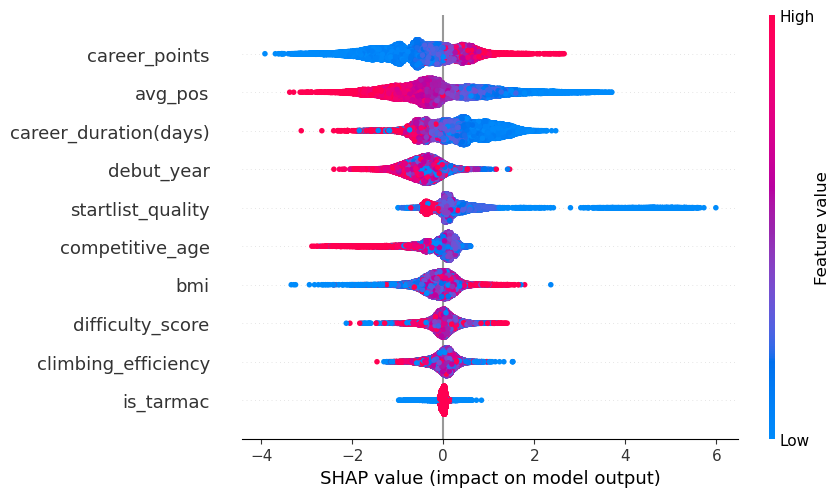

In [12]:
shap.plots.beeswarm(interventional_explanations)

The plot shows on the Y-axis the name of the features ordered by their impact on the model output, on the X-axis the SHAP values. The color of the points represents the value of the feature from low to high.
The plot is generated with `interventional` perturbation method that takes into account relationships in the data.

Looking at it we can say that:
- `career_points` has a strong negative impact on the model's output when the values are low and a positive impact when the values are high.
- `avg_pos` has mostly negative SHAP values when the feature value is high, suggesting that worse positions reduce the model's output.
- Low `career_duration(days)` contribute positively on the prediction.
- High `debut_year` contribute negatively on the prediction, suggesting that newer cyclists are less likely to be in the top 20.
- `startlist_quality` shows almost a positive impact for low values.


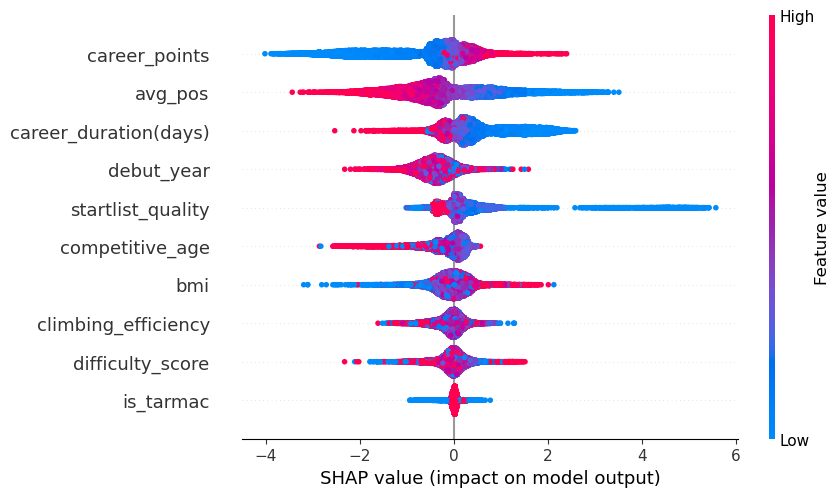

In [13]:
shap.plots.beeswarm(distributional_explanations)

This plot has been made by using the `tree_path_dependent` method where the feature impacts are reflected by the tree during training.
From the graph we can say that:
- `career_points` has mostly a negative impact on the model's output when the values are low and a positive impact when the values are high.
- `avg_pos` has the highest impact where higher values have a negative impact on the model's output.
- `career_duration(days)` has mostly a positive impact for low values.
- `debut year` has a negative impact for high values.
- `career_duration(days)` again has a positive impact for low values.

## Perturbation differences in Shap

Now we study the distribution of maximum differences per instance between the SHAP values obtained using interventional and tree_path_dependent perturbation methods.

In [14]:
import seaborn


explanation_differences = interventional_explanations.values - distributional_explanations.values
scaling_value = max((abs(interventional_explanations.values).max(), abs(distributional_explanations.values).max()))
maximum_differences_per_instance = explanation_differences.max(axis=1)
maximum_differences_per_feature = explanation_differences.max(axis=0)

<Axes: ylabel='Density'>

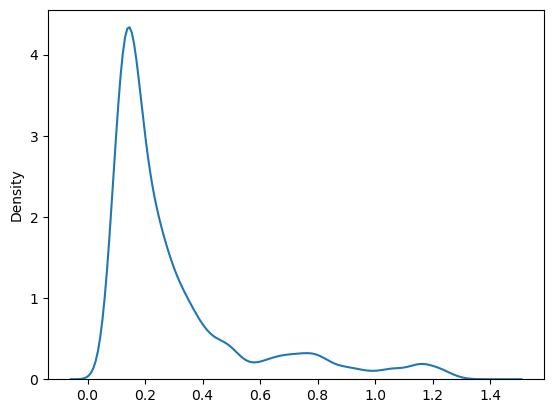

In [15]:
seaborn.kdeplot(maximum_differences_per_instance)

Here the X-axis represents the maximum difference between the SHAP values obtained using the two perturbation methods, while the Y-axis represents the density of the instances.

Most instances have a maximum SHAP differece around 0.2 indicating that the two methods are not very different in their predictions, the two explanation methods yield fairly similar results with small differences. The density drops after 0.6, indicating that large differences are rare, indicating that the two methos mostly align in their predictions..

Now we study which features have the highest differences in SHAP values between the two perturbation methods.

['bmi', 'career_points', 'career_duration(days)', 'debut_year', 'difficulty_score', 'competitive_age', 'is_tarmac', 'climbing_efficiency', 'startlist_quality', 'avg_pos']


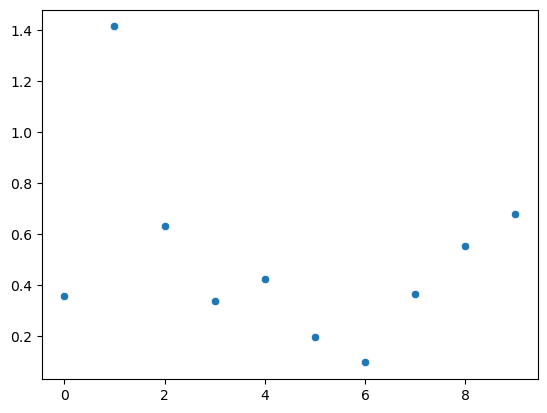

In [16]:
seaborn.scatterplot(maximum_differences_per_feature)
print(train_data.columns.tolist())

From the plot we can tell that `career_points` has the highest maximum difference (around 1.4). This means that the two methods diverge significantly for this feature, other features like `is_tarmac` and `competitive_age` are less affeccted by the chosen perturbation method and have in both methods impact similarly, other features like `debut_year` and `climbing_efficiency` fall in between, showing moderate differences.

## Explanation analysis

Are some features generally more impactful?

In [17]:
interventional_explanations_df = pd.DataFrame(interventional_explanations.values, columns=train_data.columns.tolist())
interventional_explanations_df.describe().drop("count", axis="rows")

,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos
mean,-0.116001,-0.506832,0.309739,-0.432089,-0.015865,-0.152278,-0.005030,-0.002946,0.235681,-0.099005
std,0.371103,0.870802,0.700610,0.365037,0.276714,0.458998,0.089113,0.262612,0.744266,0.996696
min,-3.341725,-3.919811,-3.121787,-2.404488,-2.132431,-2.888577,-0.981117,-1.457350,-0.996112,-3.375617
25%,-0.311784,-1.090471,-0.248245,-0.664997,-0.147025,-0.332338,-0.029817,-0.134057,-0.058711,-0.740171
50%,-0.085630,-0.465332,0.320328,-0.410644,-0.003689,-0.004392,0.002592,0.032323,0.110466,-0.235223
75%,0.116647,0.144845,0.848617,-0.186312,0.140666,0.143991,0.028399,0.156838,0.356055,0.533430
max,2.362758,2.656290,2.471582,1.459402,1.404031,0.603322,0.838852,1.528369,5.989956,3.703944


From the table we can see that `debut_year` has the highest absolute value of SHAP values, indicating that it is the most impactful feature in the model, while `is_tarmac` is the least impactful feature. Based on the `mean` and `std` values, we can say that the most impactful features are (in order):
- `career_points`
- `debut_year`
- `career_duration(days)`
- `startlist_quality`
- `avg_pos`

For what instances are some features more/less impactful?

<Axes: xlabel='debut_year', ylabel='Density'>

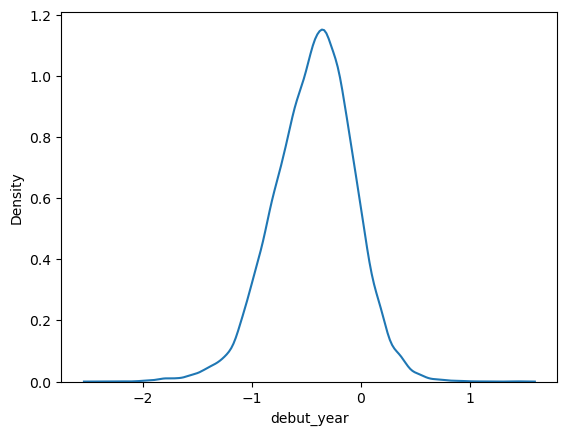

In [18]:
feature_of_interest = "debut_year"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

In [19]:
number_quantiles = 40
quantiles = interventional_explanations_df["debut_year"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    1.225269
0.050    0.137511
0.075    0.078767
0.100    0.060920
0.125    0.051572
0.150    0.042965
0.175    0.039013
0.200    0.037810
0.225    0.033282
0.250    0.032382
0.275    0.029723
0.300    0.028421
0.325    0.026414
0.350    0.027174
0.375    0.026358
0.400    0.024335
0.425    0.024611
0.450    0.023522
0.475    0.022202
0.500    0.021594
0.525    0.022131
0.550    0.021499
0.575    0.021735
0.600    0.021492
0.625    0.020211
0.650    0.022626
0.675    0.024538
0.700    0.022762
0.725    0.022879
0.750    0.024458
0.775    0.026232
0.800    0.027728
0.825    0.029479
0.850    0.032541
0.875    0.036345
0.900    0.042137
0.925    0.050391
0.950    0.073266
0.975    0.101604
Name: debut_year, dtype: float64

<Axes: xlabel='startlist_quality', ylabel='Density'>

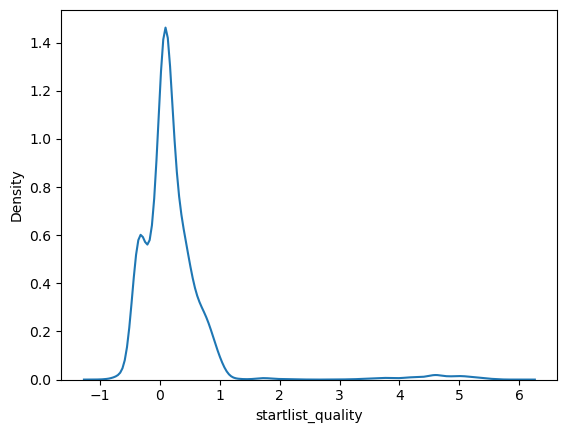

In [20]:
feature_of_interest = "startlist_quality"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

In [21]:
number_quantiles = 40
quantiles = interventional_explanations_df["startlist_quality"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    0.564458
0.050    0.038776
0.075    0.028601
0.100    0.030109
0.125    0.033735
0.150    0.046612
0.175    0.054437
0.200    0.054519
0.225    0.047225
0.250    0.038930
0.275    0.034476
0.300    0.024895
0.325    0.019954
0.350    0.015117
0.375    0.013549
0.400    0.012321
0.425    0.011972
0.450    0.012069
0.475    0.012202
0.500    0.012623
0.525    0.013582
0.550    0.014069
0.575    0.016846
0.600    0.018460
0.625    0.021289
0.650    0.026988
0.675    0.028274
0.700    0.032060
0.725    0.036522
0.750    0.037499
0.775    0.040451
0.800    0.036952
0.825    0.043739
0.850    0.057405
0.875    0.066616
0.900    0.079206
0.925    0.088337
0.950    0.100659
0.975    0.721738
Name: startlist_quality, dtype: float64

<Axes: xlabel='career_points', ylabel='Density'>

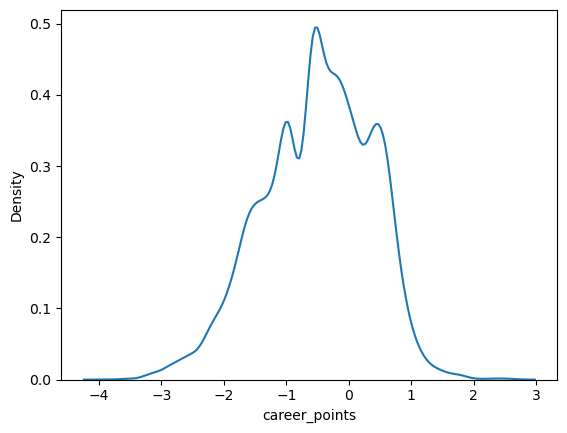

In [22]:
feature_of_interest = "career_points"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

In [23]:
number_quantiles = 40
quantiles = interventional_explanations_df["career_points"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    1.623797
0.050    0.297497
0.075    0.188888
0.100    0.128974
0.125    0.107844
0.150    0.100598
0.175    0.098652
0.200    0.100445
0.225    0.094716
0.250    0.087929
0.275    0.067286
0.300    0.056280
0.325    0.057944
0.350    0.087960
0.375    0.111909
0.400    0.066180
0.425    0.047225
0.450    0.040857
0.475    0.040845
0.500    0.048653
0.525    0.058399
0.550    0.059783
0.575    0.057383
0.600    0.063685
0.625    0.053804
0.650    0.056339
0.675    0.058408
0.700    0.069368
0.725    0.061471
0.750    0.071537
0.775    0.080626
0.800    0.081560
0.825    0.075787
0.850    0.061243
0.875    0.067017
0.900    0.070000
0.925    0.072739
0.950    0.104438
0.975    0.173138
Name: career_points, dtype: float64

<Axes: xlabel='career_duration(days)', ylabel='Density'>

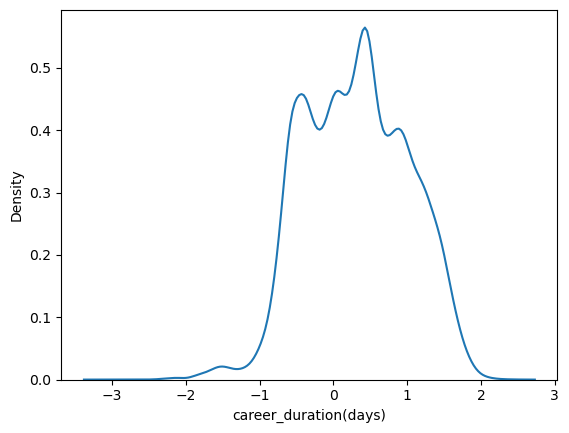

In [24]:
feature_of_interest = "career_duration(days)"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

number_quantiles = 40
quantiles = interventional_explanations_df["career_duration(days)"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

<Axes: xlabel='avg_pos', ylabel='Density'>

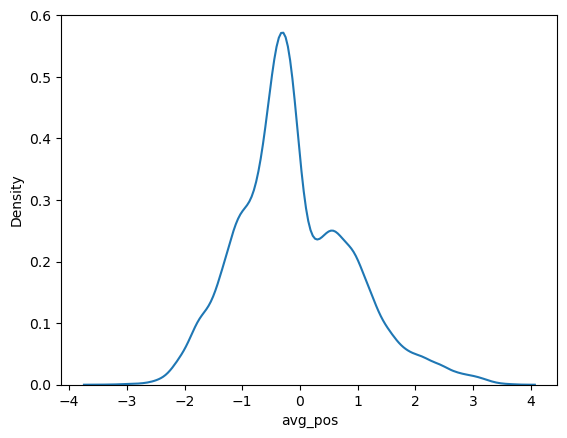

In [25]:
feature_of_interest = "avg_pos"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

In [26]:
number_quantiles = 40
quantiles = interventional_explanations_df["avg_pos"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    1.543306
0.050    0.215092
0.075    0.190908
0.100    0.132366
0.125    0.114460
0.150    0.095055
0.175    0.086832
0.200    0.085202
0.225    0.088760
0.250    0.083464
0.275    0.071502
0.300    0.068108
0.325    0.058959
0.350    0.052738
0.375    0.043680
0.400    0.045131
0.425    0.040353
0.450    0.042603
0.475    0.039826
0.500    0.042048
0.525    0.044496
0.550    0.041839
0.575    0.046404
0.600    0.053066
0.625    0.068908
0.650    0.092628
0.675    0.105775
0.700    0.114402
0.725    0.104944
0.750    0.096192
0.775    0.095850
0.800    0.100156
0.825    0.113102
0.850    0.108919
0.875    0.123309
0.900    0.146838
0.925    0.203143
0.950    0.291328
0.975    0.472375
Name: avg_pos, dtype: float64

The output shows a large initial differente from quantile 0 to 0.025 indicating that the SHAP values for `startlist_quality` at the lower end of the distribution vary more significantly than higher quantiles.

This means that the feature `startlist_quality` has a high impact on predictions for instances where its value is very low.

In [27]:
import numpy

quantile_of_interest = quantiles[0.1]
interested_explanations = interventional_explanations_df[feature_of_interest].values

highly_impacted_instances = numpy.argwhere(interested_explanations <= quantile_of_interest).squeeze()
moderately_impacted_instances = numpy.array([i for i in range(interventional_explanations.shape[0]) if i not in highly_impacted_instances])

## What are the differences in instances for which the selected features is highly important?

In [28]:
full_dataset.iloc[highly_impacted_instances].describe().drop("count", axis="rows") - full_dataset.iloc[moderately_impacted_instances].describe().drop("count", axis="rows")

,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos
mean,-0.029937,1007.582475,18.077520,5.569879,0.030775,-0.068847,-0.000337,-0.001125,-5.727765,1.690758
std,-0.192326,-1206.943543,-10.623824,-2.690473,0.004821,-0.074335,0.000610,-0.002393,-2.553485,0.409207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000454,186.000000,0.000000
25%,0.061971,1180.000000,18.000000,25.000000,0.020890,0.000000,0.000000,0.000110,0.000000,0.720822
50%,0.135851,2390.000000,40.000000,3.000000,0.039593,0.000000,0.000000,0.000228,-32.000000,7.785115
75%,-0.070805,1530.000000,30.000000,1.000000,0.092227,0.000000,0.000000,0.000384,-28.000000,1.190309
max,-0.867358,-150.000000,-3.000000,0.000000,-0.080688,0.000000,0.000000,0.000000,-106.000000,-9.312668


<Axes: xlabel='career_points', ylabel='Density'>

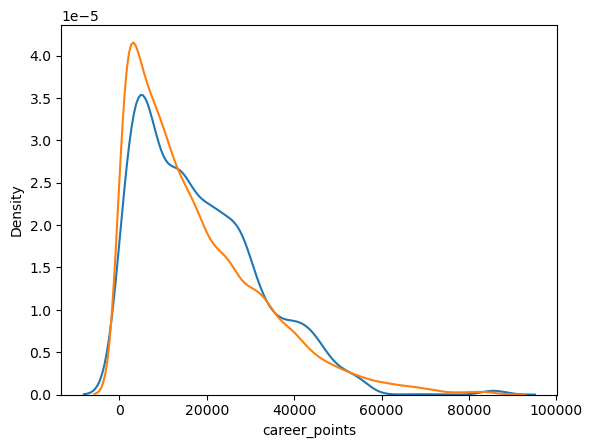

In [29]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="career_points")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="career_points")

<Axes: xlabel='career_duration(days)', ylabel='Density'>

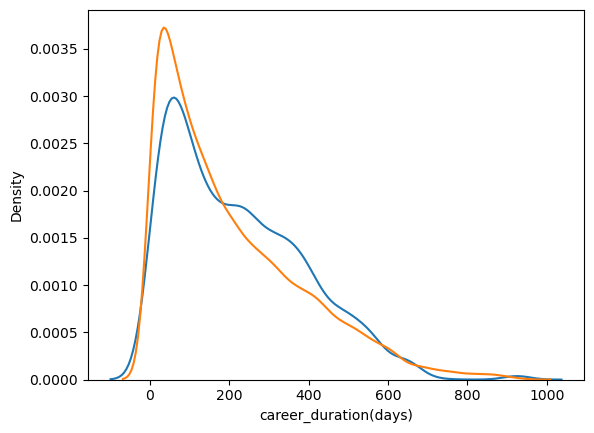

In [30]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="career_duration(days)")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="career_duration(days)")

The model is more sensitive to the selected feature for individuals with lower career_points, which may indicate an interaction between the feature and career performance.

<Axes: xlabel='debut_year', ylabel='Density'>

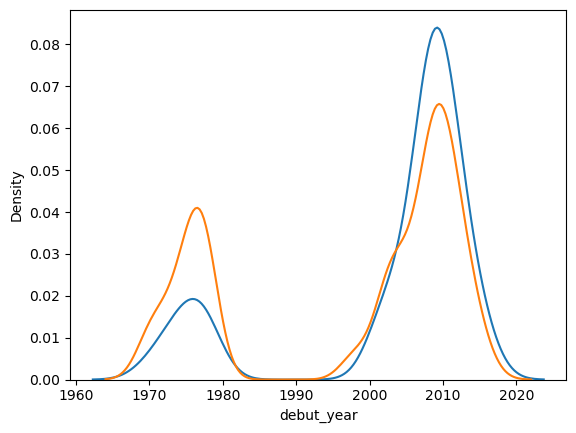

In [31]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="debut_year")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="debut_year")

According to the graph the model attributes greate sensitivity to the debut year for earlier debut years.

<Axes: xlabel='startlist_quality', ylabel='Density'>

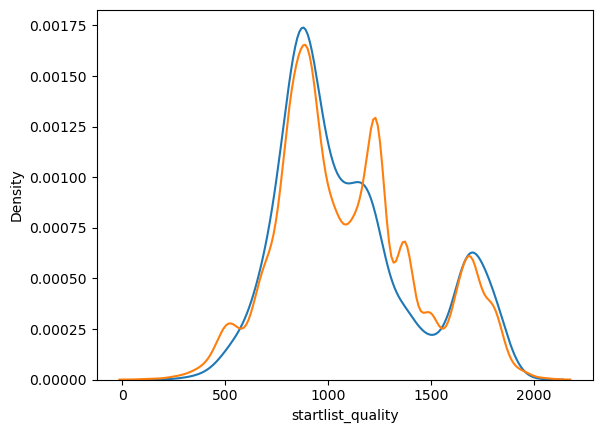

In [32]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="startlist_quality")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="startlist_quality")

<Axes: xlabel='avg_pos', ylabel='Density'>

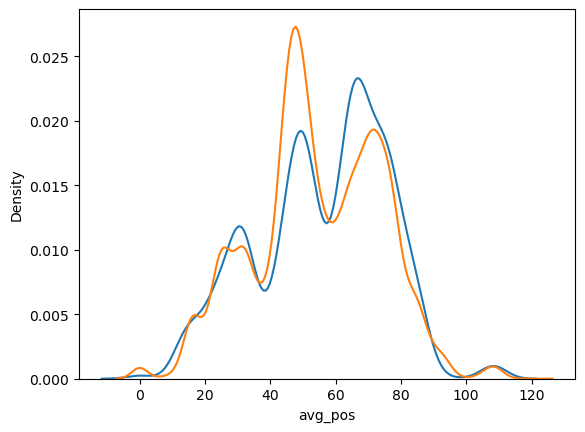

In [33]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="avg_pos")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="avg_pos")

The model has a peak on lower positions (in particular between 40 and 60), so the higly impacted instances tend to have a lower average position.

## Validation
In this section we see how the introduction of noise in the features affects the model's predictions. For this task we confront the accuracy on the initial dataset with the accuracy on the dataset with added noise.


In [34]:
pd.DataFrame(validation)

,0,1,accuracy,macro avg,weighted avg
precision,0.915224,0.298572,0.737191,0.606898,0.824884
recall,0.762732,0.588394,0.737191,0.675563,0.737191
f1-score,0.832049,0.396132,0.737191,0.614090,0.768187
support,30219.000000,5187.000000,0.737191,35406.000000,35406.000000


In [35]:
mean_absolute_importances = interventional_explanations_df.abs().mean()
features_by_importance = interventional_explanations_df.columns[mean_absolute_importances.argsort()].tolist()
features_by_importance

['is_tarmac',
 'climbing_efficiency',
 'difficulty_score',
 'bmi',
 'competitive_age',
 'startlist_quality',
 'debut_year',
 'career_duration(days)',
 'avg_pos',
 'career_points']

Now we generate a set of corrupted versions of the `test_data` dataset by adding random noise to the features of the dataset. 

In [36]:
random_noise = numpy.random.rand(test_data.shape[0],)
noise_magnitudes = [eps / 10 for eps in range(1, 10)]

corruptions_by_feature_and_noise = dict()
for feature in features_by_importance:
    for noise_magnitude in noise_magnitudes:
        corruptions_by_feature_and_noise[(feature, noise_magnitude)] = test_data.copy()
        corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] = corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] + random_noise * noise_magnitude

Now we validate the model on the corrupted datasets and compare the accuracy with the accuracy on the original dataset.

In [37]:
validations_by_feature_and_noise = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise.items():
    validations_by_feature_and_noise[(feature, noise)] = classification_report(test_labels, xgbc.predict(corruption), output_dict=True)

In [38]:
metric = "f1-score"
corruption_validation = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["weighted avg"][metric], "shap")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation["difference"] = corruption_validation["performance"] - validation["weighted avg"][metric]
corruption_validation

,feature,noise_magnitude,performance,algorithm,difference
0,is_tarmac,0.1,0.768187,shap,0.0
1,is_tarmac,0.2,0.768187,shap,0.0
2,is_tarmac,0.3,0.768187,shap,0.0
3,is_tarmac,0.4,0.768187,shap,0.0
4,is_tarmac,0.5,0.768187,shap,0.0
...,...,...,...,...,...
85,career_points,0.5,0.768187,shap,0.0
86,career_points,0.6,0.768187,shap,0.0
87,career_points,0.7,0.768187,shap,0.0
88,career_points,0.8,0.768187,shap,0.0


In [39]:
corruption_validation.groupby("feature").describe()[["performance", "difference"]]

performance                                              \
                            count      mean           std       min       25%   
feature                                                                         
avg_pos                       9.0  0.769606  6.935917e-04  0.768366  0.769323   
bmi                           9.0  0.760327  3.721662e-03  0.754353  0.758479   
career_duration(days)         9.0  0.768187  1.177569e-16  0.768187  0.768187   
career_points                 9.0  0.768187  1.177569e-16  0.768187  0.768187   
climbing_efficiency           9.0  0.724511  2.679263e-03  0.721867  0.722407   
competitive_age               9.0  0.768187  1.177569e-16  0.768187  0.768187   
debut_year                    9.0  0.768187  1.177569e-16  0.768187  0.768187   
difficulty_score              9.0  0.759471  6.904934e-03  0.749484  0.753999   
is_tarmac                     9.0  0.768187  1.177569e-16  0.768187  0.768187   
startlist_quality             9.0  0.768187  1.177569e-16  0.768187  0.768187   

                                                    difference            \
                            50%       75%       max      count      mean   
feature                                                                    
avg_pos                0.769839  0.770139  0.770259        9.0  0.001419   
bmi                    0.760371  0.763004  0.765739        9.0 -0.007860   
career_duration(days)  0.768187  0.768187  0.768187        9.0  0.000000   
career_points          0.768187  0.768187  0.768187        9.0  0.000000   
climbing_efficiency    0.723904  0.725215  0.729256        9.0 -0.043676   
competitive_age        0.768187  0.768187  0.768187        9.0  0.000000   
debut_year             0.768187  0.768187  0.768187        9.0  0.000000   
difficulty_score       0.761258  0.764421  0.768638        9.0 -0.008715   
is_tarmac              0.768187  0.768187  0.768187        9.0  0.000000   
startlist_quality      0.768187  0.768187  0.768187        9.0  0.000000   

                                                                         \
                            std       min       25%       50%       75%   
feature                                                                   
avg_pos                0.000694  0.000180  0.001137  0.001652  0.001952   
bmi                    0.003722 -0.013834 -0.009708 -0.007815 -0.005183   
career_duration(days)  0.000000  0.000000  0.000000  0.000000  0.000000   
career_points          0.000000  0.000000  0.000000  0.000000  0.000000   
climbing_efficiency    0.002679 -0.046320 -0.045779 -0.044283 -0.042971   
competitive_age        0.000000  0.000000  0.000000  0.000000  0.000000   
debut_year             0.000000  0.000000  0.000000  0.000000  0.000000   
difficulty_score       0.006905 -0.018703 -0.014188 -0.006929 -0.003766   
is_tarmac              0.000000  0.000000  0.000000  0.000000  0.000000   
startlist_quality      0.000000  0.000000  0.000000  0.000000  0.000000   

                                 
                            max  
feature                          
avg_pos                0.002073  
bmi                   -0.002447  
career_duration(days)  0.000000  
career_points          0.000000  
climbing_efficiency   -0.038930  
competitive_age        0.000000  
debut_year             0.000000  
difficulty_score       0.000451  
is_tarmac              0.000000  
startlist_quality      0.000000

Looking at the table we can say that:
- `career_duration(days)`, `career_points`, `competitive_age`, `debut_year`, `is_tarmac` and `startlist_quality` have a mean difference of 0.0 or close to 0, so the performance remains unaffected by noise in these features; and
-  `climbing_efficiency`, `bmi`, `difficulty_score` and `avg_pos` show more variability in performance so they are more sensitive to noise.

In [40]:
grouped_data = corruption_validation.groupby("noise_magnitude").describe()[["performance", "difference"]]
grouped_data

performance                                                    \
                      count      mean       std       min       25%       50%   
noise_magnitude                                                                 
0.1                    10.0  0.764112  0.012274  0.729256  0.768187  0.768187   
0.2                    10.0  0.763718  0.012448  0.728475  0.766960  0.768187   
0.3                    10.0  0.762774  0.014510  0.721867  0.765362  0.768187   
0.4                    10.0  0.762545  0.013870  0.724030  0.764121  0.768187   
0.5                    10.0  0.762610  0.013510  0.725215  0.762990  0.768187   
0.6                    10.0  0.762080  0.014033  0.723904  0.762325  0.768187   
0.7                    10.0  0.761474  0.014463  0.723085  0.760906  0.768187   
0.8                    10.0  0.760860  0.014949  0.722407  0.759062  0.768187   
0.9                    10.0  0.760557  0.015143  0.722355  0.757811  0.768187   

                                    difference                                \
                      75%       max      count      mean       std       min   
noise_magnitude                                                                
0.1              0.768187  0.768638       10.0 -0.004075  0.012274 -0.038930   
0.2              0.768187  0.768652       10.0 -0.004469  0.012448 -0.039712   
0.3              0.768187  0.769323       10.0 -0.005413  0.014510 -0.046320   
0.4              0.768187  0.769615       10.0 -0.005641  0.013870 -0.044157   
0.5              0.768187  0.769839       10.0 -0.005576  0.013510 -0.042971   
0.6              0.768187  0.770139       10.0 -0.006106  0.014033 -0.044283   
0.7              0.768187  0.770059       10.0 -0.006712  0.014463 -0.045102   
0.8              0.768187  0.770198       10.0 -0.007326  0.014949 -0.045779   
0.9              0.768187  0.770259       10.0 -0.007630  0.015143 -0.045832   

                                               
                      25%  50%  75%       max  
noise_magnitude                                
0.1              0.000000  0.0  0.0  0.000451  
0.2             -0.001227  0.0  0.0  0.000465  
0.3             -0.002824  0.0  0.0  0.001137  
0.4             -0.004066  0.0  0.0  0.001428  
0.5             -0.005197  0.0  0.0  0.001652  
0.6             -0.005862  0.0  0.0  0.001952  
0.7             -0.007281  0.0  0.0  0.001872  
0.8             -0.009125  0.0  0.0  0.002012  
0.9             -0.010376  0.0  0.0  0.002073

The classifier is relatively robust to small levels of noise (e.g. for magnitude lecels of 0.1) ad both the mean performance and the difference are close to the baseline values, however as noise increases it may not be robust to high-noise environments.

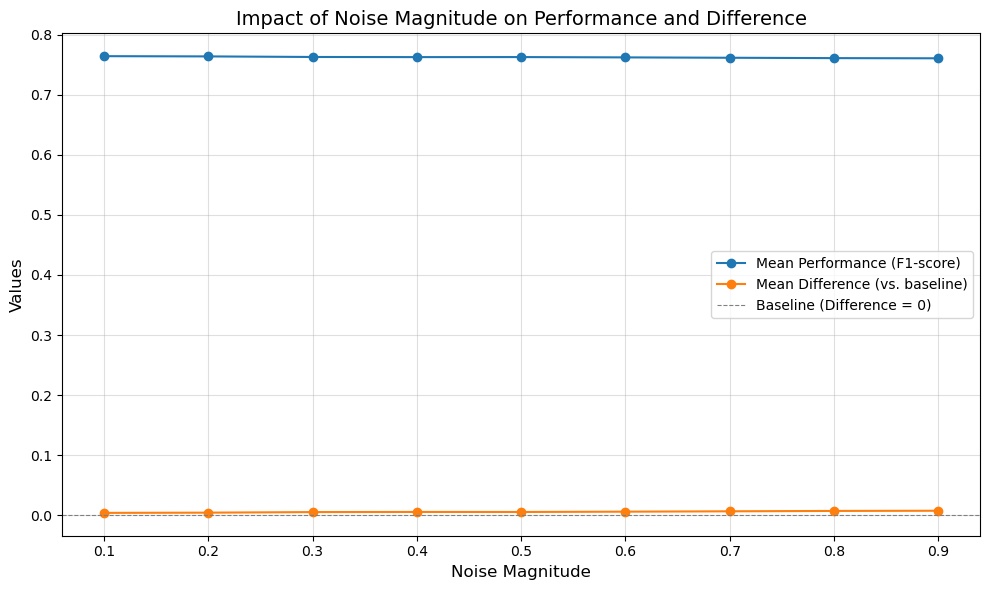

In [54]:
import matplotlib.pyplot as plt

noise_magnitude = grouped_data.index
performance_mean = grouped_data[("performance", "mean")]
difference_mean = - grouped_data[("difference", "mean")]

plt.figure(figsize=(10, 6))

plt.plot(
    noise_magnitude,
    performance_mean,
    marker='o',
    label="Mean Performance (F1-score)"
)

plt.plot(
    noise_magnitude,
    difference_mean,
    marker='o',
    label="Mean Difference (vs. baseline)"
)

plt.title("Impact of Noise Magnitude on Performance and Difference", fontsize=14)
plt.xlabel("Noise Magnitude", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, label="Baseline (Difference = 0)")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()

## Rule explanation

In this part we concentrate on the explanation on the rule explanation of the XGBOOST Model. To do so, we use the `LORE(Local Rule-based Explanations)` algorithm which uses local explanations based on rules for the prediction of the model.

In [42]:
from xailib.explainers.lore_explainer import LoreTabularExplainer

explanation_algorithm = LoreTabularExplainer(xgbc)

configuration = {
    "neigh_type": "rndgen",
    "size": 1000,
    "ocr":0.1,
    "ngen": 100
}

lore_train_data = pd.concat((train_data, train_labels), axis="columns")
explanation_algorithm.fit(lore_train_data, "top_20", config=configuration)
explanation = explanation_algorithm.explain(train_data.iloc[10000].values)


In [43]:
print(train_data.iloc[10000])

bmi                         20.571429
career_points            22335.000000
career_duration(days)      305.000000
debut_year                2011.000000
difficulty_score             1.153083
competitive_age             25.000000
is_tarmac                    1.000000
climbing_efficiency          0.013842
startlist_quality          985.000000
avg_pos                     53.885246
Name: 14877, dtype: float64


Now the `explanation` object contains the rules that the model uses to make predictions. We can now get the rules by running the `get_rules` method on the `explanation` object.

In [44]:
explanation.plotRules()

These rules are satsfied by the instance where the model make the prediction, and so the instance is classified as `0`.
If we want to know how to change the classification of the instance from `0` to `1`, we need the counterfactual rules. 

Now we can use the method `getCounterfactualRules` to get the counterfactual rules for the prediction of the model. The counterfactual rules are the rules that need to be satisfied in order to change the prediction of the model. 

In [45]:
explanation.getCounterfactualRules()

[{'premise': [{'att': 'career_points',
    'op': '<=',
    'thr': 3402.5,
    'is_continuous': True},
   {'att': 'avg_pos',
    'op': '>',
    'thr': 30.097487449645996,
    'is_continuous': True},
   {'att': 'bmi',
    'op': '<=',
    'thr': 23.235782623291016,
    'is_continuous': True},
   {'att': 'difficulty_score',
    'op': '<=',
    'thr': 2.5545934438705444,
    'is_continuous': True},
   {'att': 'debut_year', 'op': '>', 'thr': 1992.5, 'is_continuous': True},
   {'att': 'startlist_quality',
    'op': '>',
    'thr': 383.5,
    'is_continuous': True}],
  'cons': 0,
  'class_name': 'top_20'},
 {'premise': [{'att': 'career_points',
    'op': '>',
    'thr': 12767.5,
    'is_continuous': True},
   {'att': 'bmi', 'op': '>', 'thr': 20.496676445007324, 'is_continuous': True},
   {'att': 'avg_pos',
    'op': '<=',
    'thr': 62.02945137023926,
    'is_continuous': True},
   {'att': 'career_duration(days)',
    'op': '>',
    'thr': 19.0,
    'is_continuous': True},
   {'att': 'competit

Now with the counterfactual rules we can create counterfactual instances that change the prediction of the model. If the counterfactual rules of the premise are satisfied, the prediction of the model will change. We will do it in the next step.

In [46]:
explanation.expDict["fidelity"]

0.9921541239354318

This fidelity tell us that the local model agrees with the predctions of the global model 99.7% of the synthetic neighbors used to build the local explanation.

## Counterfactual instances

Here we provide the counterfactual explanations for the XGBOOST model. Counterfactual explanations are the instances that need to be changed in order to change the prediction of the model. To do it we use the `dice_ml` library.

In [47]:
import dice_ml

# need to convert data to the Dice format
dice_train_dataset = train_data.copy()
dice_train_dataset["top_20"] = train_labels
dice_dataset = dice_ml.Data(
    dataframe=dice_train_dataset,
    outcome_name="top_20",
    continuous_features=dice_train_dataset.columns.tolist()[:-1]
)

dice_model = dice_ml.Model(
    model=xgbc,
    backend="sklearn",  # dice supports several frameworks, e.g., pytorch, tensorflow
)


In [48]:
# the Dice object interfaces the counterfactual search
explanation_algorithm = dice_ml.Dice(
    dice_dataset,
    dice_model,
    method="random"  # random search for counterfactuals
    # method="gradient"  # gradient ASCent
    # method="genetic"  # genetic algorithm for search
)

explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.iloc[[10000]].drop("top_20", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
)

100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


We print the counterfactual explanations generated by DiCE for a specific query instance.

In [49]:
explanation.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,20.571428,22335.0,305.0,2011.0,1.153083,25,1,0.013842,985,53.885246,1



Diverse Counterfactual set (new outcome: 0)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,23.269871,-,871.4,-,-,-,-,-,-,-,0.0
1,21.330381,-,546.6,-,-,-,-,-,-,-,0.0
2,-,-,557.6,-,-,-,-,-,-,-,0.0
3,-,-,-,-,-,-,-,0.164676432,-,63.7,0.0
4,19.768286,-,-,-,-,-,-,-,-,155.1,0.0
5,-,-,-,-,-,19.0,0.0,-,-,-,0.0
6,-,-,-,-,-,45.0,-,-,-,-,0.0
7,17.211664,-,-,-,-,39.0,-,-,-,-,0.0
8,-,-,415.7,-,-,-,-,-,-,-,0.0
9,-,-,-,-,-,19.0,-,-,-,-,0.0


In [55]:
import numpy as np

explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.iloc[[10000]].drop("top_20", axis="columns"),
    total_CFs=20,  # number of counterfactuals to generate
    permitted_range = {
        "debut_year": (1992.5, 2023.0),           
        "avg_pos": (30.1, 62.03),                 
        "career_points": (0, 12767.5),           
        "startlist_quality": (383.5, 938.5),     
        "competitive_age": (32.5, 35.5),         
        "climbing_efficiency": (0.0125, 0.0176), 
        "career_duration(days)": (19.0, 85.0)    
    },
    features_to_vary=[
        "debut_year", 
        "avg_pos", 
        "career_points", 
        "startlist_quality", 
        "competitive_age", 
        "career_duration(days)"
    ],
    stopping_threshold = 0.2
)

100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


In [56]:
explanation.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,20.571428,22335.0,305.0,2011.0,1.153083,25,1,0.013842,985,53.885246,1



Diverse Counterfactual set (new outcome: 0)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,-,-,-,-,-,35.0,-,-,-,-,0.0
1,-,-,-,-,-,35.0,-,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,-,0.0
3,-,-,49.3,-,-,-,-,-,-,-,0.0
4,-,-,-,-,-,-,-,-,781.0,-,0.0
5,-,-,-,-,-,32.0,-,-,-,-,0.0
6,-,-,-,-,-,-,-,-,820.0,-,0.0
7,-,-,-,-,-,-,-,-,-,-,0.0
8,-,-,-,-,-,-,-,-,792.0,-,0.0
9,-,-,-,-,-,-,-,-,-,-,0.0


Now we generate the counterfactuals for the XGBOOST model. We take the first instance from `dice_train_dataset` to generate the counterfactuals. 

In [57]:
explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.iloc[[10000]].drop("top_20", axis="columns"),
    total_CFs=20, # number of counterfactuals to generate
    permitted_range = {
        "debut_year": (1992.5, 2023.0),           
        "avg_pos": (30.1, 62.03),                 
        "career_points": (0, 12767.5),           
        "startlist_quality": (383.5, 938.5),     
        "competitive_age": (32.5, 35.5),         
        "climbing_efficiency": (0.0125, 0.0176), 
        "career_duration(days)": (19.0, 85.0)    
    },
    features_to_vary=[
        "debut_year", 
        "avg_pos", 
        "career_points", 
        "startlist_quality", 
        "competitive_age", 
        "career_duration(days)"
    ],
    stopping_threshold = 0.2
)

100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


In [58]:
counterfactuals = explanation.cf_examples_list[0].final_cfs_df
counterfactuals

,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,20.571429,1384.3,305.0,2002.2,1.153083,25,1,0.013842,985,53.885246,0
1,20.571429,650.0,305.0,2014.0,1.153083,25,1,0.013842,985,53.885246,0
2,20.571429,1067.3,305.0,2011.0,1.153083,25,1,0.013842,985,53.885246,0
3,20.571429,1954.4,305.0,2011.0,1.153083,25,1,0.013842,985,53.885246,0
4,20.571429,1922.4,305.0,2011.0,1.153083,35,1,0.013842,985,53.885246,0
5,20.571429,1862.0,305.0,2011.0,1.153083,25,1,0.013842,712,53.885246,0
6,20.571429,1274.1,305.0,2011.0,1.153083,25,1,0.013842,985,53.885246,0
7,20.571429,448.0,305.0,2011.0,1.153083,25,1,0.013842,535,53.885246,0
8,20.571429,1504.7,305.0,2003.6,1.153083,25,1,0.013842,985,53.885246,0
9,20.571429,2080.6,305.0,2005.4,1.153083,25,1,0.013842,985,53.885246,0
